## Imports

In [1]:
!pip install arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 179 kB 13.8 MB/s 
     |████████████████████████████████| 126 kB 52.4 MB/s 
     |████████████████████████████████| 184 kB 66.2 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=eaaf64bc9d55a45693250701dfcd394a6489a39cae7fc6de5d3593855013c389
  Stored in directory: /root/.cache/pip/wheels/71/4d/3c/cada364d4ea0026deee7208dee1e61bcebd20aa2ae5dc154ba
Successfully built emoji


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 12.6 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 
     |████████████████████████████████| 182 kB 63.6 MB/s 


In [3]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from arabert.preprocess import ArabertPreprocessor
from tensorflow.keras.layers import Dense , Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Load Datasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load arabic names
real_arabic_names = pd.read_csv('drive/MyDrive/Names web dataset/Arabic_names.csv')
# load male names
male = pd.read_csv('drive/MyDrive/Names web dataset/mnames.txt', sep='\n', header=None, names=['Name'])
# load female names
female = pd.read_csv('drive/MyDrive/Names web dataset/fnames.txt', sep='\n', header=None, names=['Name'])

In [6]:
# view first rows of real arabic names
real_arabic_names.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


In [7]:
# view last 5 rows of arabic names
real_arabic_names.tail()

,Name,Gender
1400,وهبة,M
1401,ياسر,M
1402,يحيى,M
1403,يزيد,M
1404,يعقوب,M


In [8]:
# view first 5 rows of male names
male.head()

,Name
0,أبان
1,أبو بكر
2,أبو حمزة
3,أحد
4,أحمد


In [9]:
# view last 5 rows of male names
male.tail()

,Name
635,وفيق
636,وهاب
637,وهبة
638,ياسر
639,يحيى


In [10]:
# view first 5 rows of female names
female.head()

,Name
0,آيات
1,آلاء
2,آمال
3,آمنة
4,آيات


In [11]:
# view last 5 rows of female names
female.tail()

,Name
411,وميض
412,وهبة
413,يارا
414,ياسمين
415,يسرا


In [12]:
# add gender column to male and female names
male['Gender'] = 'M'
female['Gender'] = 'F'

In [13]:
# merge male names with female names
names = pd.concat([male,female])
# merge the result with arabic names
real_names = pd.concat([real_arabic_names,names])

In [14]:
# add label column to the arabic names datasets that identifies that these names are real names
real_names['Label'] = 'Real'

In [15]:
# shape of the result of merging all real arabic names datasets
real_names.shape

(2461, 3)

In [16]:
def check_duplicates(data, text):
  df = data
  # check to see if there is duplicates in rows
  print('Number of duplicated names are: ', df['Name'].duplicated().sum())
  # create mask
  duplicated_names_mask_fake = df['Name'].duplicated()
  # new arabic names dataframe without any duplicated names
  df = df[~ duplicated_names_mask_fake]
  print('The shape of ', text, 'after deleting duplicates is:', df.shape)
  # reset index
  df = df.reset_index(drop=True)
  return df

In [17]:
# check and remove duplicates
names = check_duplicates(real_names, 'real names')

Number of duplicated names are:  909
The shape of  real names after deleting duplicates is: (1552, 3)


In [18]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1552 non-null   object
 1   Gender  1552 non-null   object
 2   Label   1552 non-null   object
dtypes: object(3)
memory usage: 36.5+ KB


In [19]:
names.describe()

,Name,Gender,Label
count,1552,1552,1552
unique,1552,2,1
top,ابتسام,M,Real
freq,1,929,1552


## Data generation

In [20]:
arabic_alphabet = ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 
                     'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'أ', 'ؤ', 
                     'ة', 'آ', 'ء', 'ئ', 'إ']

In [21]:
class DataGenerator:
    
    def __init__(self, alpha):
        self.alphabet = alpha
    
    def generate(self, mode, num_of_words, name, gender):
        generated_data = dict()
        generated_names = []
        generated_gender = []
        generated_label = ['Fake'] * num_of_words
        i = 0
        while i < num_of_words:
            random_index = random.randint(0, (len(name) - 1))
            if mode == 'replace_char':
                alpha_random_index = random.randint(0, (len(self.alphabet) - 1))
                fake_name = name.replace(name[random_index], self.alphabet[alpha_random_index])
            elif mode == 'delete_char':
                fake_name = name.replace(name[random_index], "")
            elif mode == 'add_char':
                alpha_random_index = random.randint(0, (len(self.alphabet) - 1))
                fake_name = name[:random_index] + self.alphabet[alpha_random_index] + name[random_index:]
            if fake_name in generated_names:
                continue
            generated_names.append(fake_name)
            generated_gender.append(gender)
            i = i + 1
        generated_data['Name'] = generated_names
        generated_data['Gender'] = generated_gender
        generated_data['Label'] = generated_label        
        return generated_data
    
    def generate_full_name(self, mode, data, num_of_names):
        generated_data = dict()
        generated_first_last_names = []
        generated_full_names = []
        generated_gender = []
        generated_label = []
        # first name and second name
        names = list(data['Name'].values)
        genders = list(data['Gender'].values)
        for name, gender in zip(names, genders):
          counter1 = 0
          while True:
            if counter1 >= num_of_names:
              break
            index2 = random.randint(0,(len(names) - 1))
            if genders[index2] == 'F':
              continue
            first_last_name = name + ' ' + names[index2]
            generated_first_last_names.append(first_last_name)
            generated_gender.append(gender)
            if mode == 'Real':
              generated_label.append('Correct')
            elif mode == 'Fake':
              generated_label.append('Incorrect')
            counter1 = counter1 + 1
        # full name
        for name in  generated_first_last_names:
          while True:
            index2 = random.randint(0,(len(names) - 1))
            if genders[index2] == 'F':
              continue
            else:
              break
          full_name = name + ' ' + names[index2]
          generated_full_names.append(full_name)
        generated_data['Name'] = generated_full_names
        generated_data['Gender'] = generated_gender
        generated_data['Label'] = generated_label  
        return pd.DataFrame.from_dict(generated_data)

In [22]:
# create object of the DataGenerator class
generator = DataGenerator(arabic_alphabet)

For each name in the **_Arabic Names Dataset_**, we will generate **two** fake names by deleting a random character from the original name at random position, then generate **six** fake names by adding a  wrong character to the original name at random position, and **four** fake names by replacing a random single character from the original name with another wrong random character

**IMPORTANT NOTE**, we will not consider all possibilities of generating a fake name from an original name, as this will lead us to huge fake names maybe reach to more than **500,000!** fake name, So as a start it will be enough to generate **12x** fake names from the real names dataset

In [23]:
# generate 2 fake names by delete a char
f_names_deleted_char = names.apply(lambda x: generator.generate(mode='delete_char', num_of_words=2, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 4 fake names by replace a char
f_names_replaced_char = names.apply(lambda x: generator.generate(mode='replace_char', num_of_words=4, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 6 fake names by adding a wrong char
f_names_adding_wrong_char = names.apply(lambda x: generator.generate(mode='add_char', num_of_words=6, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)

In [24]:
# this function is used to re-represent the output of the generator to make it one dictionary instead of a 
# dictionary for each name, to convert the dictionary to a dataframe
def one_dict(multi_dict):
    dic = dict()
    name = []
    gender = []
    label = []
    for row in multi_dict:
        for names in row['Name']:
            name.append(names)
        for genders in row['Gender']:
            gender.append(genders)
        for labels in row['Label']:
            label.append(labels)  
    dic['Name'] = name
    dic['Gender'] = gender
    dic['Label'] = label
    return dic

In [25]:
# convert the output of the generator to one dictionary containing all names
deleted_char_dict = one_dict(f_names_deleted_char)
replaced_char_dict = one_dict(f_names_replaced_char)
added_char_dcit = one_dict(f_names_adding_wrong_char)
# convert the dictionaries into dataframe form
deleted_char_df = pd.DataFrame.from_dict(deleted_char_dict)
replaced_char_df = pd.DataFrame.from_dict(replaced_char_dict)
added_char_df = pd.DataFrame.from_dict(added_char_dcit)
# concatenate the 3 dataframe to form the Fake Names Dataset
f_names = pd.concat([added_char_df, replaced_char_df, deleted_char_df],ignore_index=True)

In [26]:
# view first 5 rows of fake names
f_names.head()

,Name,Gender,Label
0,لابتسام,F,Fake
1,اببتسام,F,Fake
2,رابتسام,F,Fake
3,ابتسانم,F,Fake
4,ابمتسام,F,Fake


In [27]:
# view last 5 rows of fake names
f_names.tail()

,Name,Gender,Label
18619,ناحة,F,Fake
18620,ميا,F,Fake
18621,منا,F,Fake
18622,نصاح,F,Fake
18623,ناحة,F,Fake


In [28]:
f_names.shape

(18624, 3)

In [29]:
f_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18624 entries, 0 to 18623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    18624 non-null  object
 1   Gender  18624 non-null  object
 2   Label   18624 non-null  object
dtypes: object(3)
memory usage: 436.6+ KB


In [30]:
f_names.describe()

,Name,Gender,Label
count,18624,18624,18624
unique,17819,2,1
top,اهر,M,Fake
freq,6,11148,18624


In [31]:
# check and remove duplicates
f_names2 = check_duplicates(f_names, 'fake names')

Number of duplicated names are:  805
The shape of  fake names after deleting duplicates is: (17819, 3)


In [32]:
# check to see if there is a fake name exist in real names
# False indicates that this name will be deleted from the fake names dataset
# True indicates that this name will remain exist in the fake names dataset
fake_real_mask = [False if name in names['Name'] else True for name in f_names2['Name']]
print('Number of fake names that exist in real arabic names', len([fake_real_mask == False]))
fake_names = f_names2[fake_real_mask]

Number of fake names that exist in real arabic names 1


We have our real arabic names dataset and generated fake names dataset from our real arabic names, We will now create a **Full Name Dataset** consists of 3 names separated by space

We will create **Two Datasets**:
1. The first is full names with real arabic names, by generating **random 162 name** for each name in the real arabic names dataset
2. the second is full names with fake arabic names, by generating **random 15 name** for each name in the fake arabic names dataset

There is a difference in number of names in each dataset and that is because the dataframe of real names is smaller than by **12X** from the dataframe that contains fake names, so above numbers will give us balanced dataset of full names with equal number of examples for each class (Correct and Incorrect)

And if we choose to generate same number of names in the two dataset this will lead to **Imbalanced Dataset Problem**, and a memory problem may occur, so above numbers are enough

In [33]:
# full names with real arabic names
full_names_real = generator.generate_full_name(mode='Real', data=names,num_of_names=162)
# full names with fake arabic names
full_names_fake = generator.generate_full_name(mode='Fake', data=fake_names,num_of_names=15)

In [34]:
# combine the two dataset together into one
full_names = pd.concat([full_names_real,full_names_fake])
# shuffle the data
full_names = full_names.sample(frac=1)
# reset index
full_names = full_names.reset_index(drop=True)

In [35]:
# view first 5 rows of the full_names dataset
full_names.head()

,Name,Gender,Label
0,قسيم حمد ساجي,M,Correct
1,هادي مضر مثاب,M,Correct
2,كهيلان أدعطج شؤمر,M,Incorrect
3,لن بادل بهو,F,Incorrect
4,حقي رابح شداد,M,Correct


In [36]:
# view last 5 rows of the full_names dataset
full_names.tail()

,Name,Gender,Label
518704,نزى عبداطططيف حازف,F,Incorrect
518705,عدإ ترفاعي سهيثم,M,Incorrect
518706,يزيد سمعون عقبة,M,Correct
518707,صفا نشمي صباح,F,Correct
518708,رهيف مكين رسمي,M,Correct


In [37]:
full_names.shape

(518709, 3)

In [38]:
full_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518709 entries, 0 to 518708
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Name    518709 non-null  object
 1   Gender  518709 non-null  object
 2   Label   518709 non-null  object
dtypes: object(3)
memory usage: 11.9+ MB


In [39]:
full_names.describe()

,Name,Gender,Label
count,518709,518709,518709
unique,518690,2,2
top,شعبة مارسيل عبدالحي,M,Incorrect
freq,2,308688,267285


In [40]:
# check and remove duplicates
full_names = check_duplicates(full_names, 'full names')

Number of duplicated names are:  19
The shape of  full names after deleting duplicates is: (518690, 3)


## Core Model

For the Core Model part i will use a **Pretrained Model** that is **AraBERT** and it is an Arabic pretrained language model based on Google's BERT architechture but for  Arabic Language Understanding

We will use the **Tokenizer** of **AraBERT** to convert our full names into tokens after that ids that represent each word to make data ready for my own Deep Learning Model

In [41]:
# load the tokenizer and preprocessor
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer =  AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name=model_name)

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Prepare the data for the **Model**

In [42]:
# drop the gender column as it wouldn't be useful anymore
full_names = full_names.drop(columns=['Gender'])
# divide data into x that represents features and y that represent target
X = full_names.drop(columns=['Label'])
y = full_names[['Label']]
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [43]:
# reset index for all data
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

This method apply all transofrmation and preprocessing for the names data, as it converts it to **Tokens** and convert tokens into **IDs** and **Encodes** the labels of the data by converting them to **One Hot Encoding** return to us the data ready to be fed into my own Deep Learning Model

In [83]:
def transform_data(X,y):
  if not isinstance(X, pd.DataFrame):
    X = {'Name': [X]}
    X = pd.DataFrame(X, index=[0], columns=['Name'])
  # apply preprocessor on the X data
  X = X['Name'].apply(lambda x: preprocessor.preprocess(x))
  # convert back to dataframe and reset_index
  X = pd.DataFrame(X,columns=['Name'])
  # tokenize X data
  X = [tokenizer.tokenize(name ,max_length=3, truncation=True) for name in X['Name'].tolist()]
  # convert tokens in X to ids
  X = [tokenizer.convert_tokens_to_ids(name) for name in X]
  # convert into numpy array
  X = np.array(X)
  if y is None:
    return X 
  else:
    # encode labels in y data
    y = pd.get_dummies(y['Label'])
    return X, y

In [45]:
# transofrm X_train and y_train data
X_train , y_train = transform_data(X_train,y_train)
# transform X_test and y_test data
X_test , y_test = transform_data(X_test,y_test)

Define my own **Model Architecture**

In [46]:
# hyperparameters
VOCAB_SIZE = 60000
MAX_LEN = 3
EMBEDDING_DIM = 16
HIDDEN_SIZE = 32
NUM_CLASSES = 2
BATCH_SIZE = 128
EPOCHS = 10
VAL_SLPIT = 0.15
OPTIMIZER = Adam()
LOSS = BinaryCrossentropy()
METRICS = ['accuracy']

In [47]:
# architecture
model = Sequential([
    Embedding(input_dim= VOCAB_SIZE, output_dim= EMBEDDING_DIM, input_length= MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(units= HIDDEN_SIZE, activation = 'relu'),
    Dense(units= NUM_CLASSES, activation='softmax')
])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 16)             960000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 960,610
Trainable params: 960,610
Non-trainable params: 0
_________________________________________________________________


In [49]:
# compile the model
model.compile(optimizer = OPTIMIZER, loss = LOSS,metrics= METRICS)
# Training...
history = model.fit(x= X_train,y= y_train, batch_size= BATCH_SIZE, epochs = EPOCHS, validation_split= VAL_SLPIT)

Epoch 1/10
2928/2928 [==============================] - 31s 10ms/step - loss: 0.1032 - accuracy: 0.9653 - val_loss: 0.0592 - val_accuracy: 0.9790
Epoch 2/10
2928/2928 [==============================] - 28s 10ms/step - loss: 0.0545 - accuracy: 0.9815 - val_loss: 0.0553 - val_accuracy: 0.9815
Epoch 3/10
2928/2928 [==============================] - 28s 9ms/step - loss: 0.0508 - accuracy: 0.9826 - val_loss: 0.0510 - val_accuracy: 0.9824
Epoch 4/10
2928/2928 [==============================] - 29s 10ms/step - loss: 0.0445 - accuracy: 0.9848 - val_loss: 0.0431 - val_accuracy: 0.9853
Epoch 5/10
2928/2928 [==============================] - 30s 10ms/step - loss: 0.0380 - accuracy: 0.9871 - val_loss: 0.0385 - val_accuracy: 0.9869
Epoch 6/10
2928/2928 [==============================] - 33s 11ms/step - loss: 0.0348 - accuracy: 0.9883 - val_loss: 0.0374 - val_accuracy: 0.9878
Epoch 7/10
2928/2928 [==============================] - 29s 10ms/step - loss: 0.0331 - accuracy: 0.9890 - val_loss: 0.0363 - 

In [50]:
def plot_curves(history):
    title_loss = 'Model loss per epoch '
    title_accuracy = 'Model accuracy per epoch '
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()


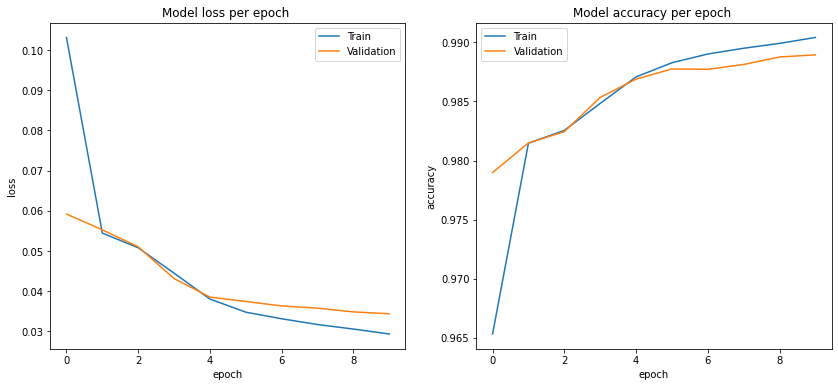

In [51]:
plot_curves(history)

Perform predictions and calculate the **accuarcy** on the Test Data to determine the performance of the model

In [74]:
def predictions(model, X_test):
  correct_pred = []
  incorrect_pred = []
  # perform predictions
  pred = model.predict(X_test)
  for x in pred:
    # this case means that the model predicts the full name is correct and its confidence is higher than the confidence of the full name being incorrect
    if x[0] > x[1]:
      correct_pred.append(1)
      incorrect_pred.append(0)
    # this case means that the model predicts the full name is incorrect and its confidence is higher than the confidence of the full name being correct
    elif x[1] > x[0]:
      incorrect_pred.append(1)
      correct_pred.append(0)
  # put predictions into a dictionary under two keys correct and incorrect
  y_pred = {'Correct': correct_pred, 'Incorrect': incorrect_pred}
  return y_pred

In [76]:
y_pred = predictions(model, X_test)
# convert predictions to dataframe
y_pred = pd.DataFrame(y_pred, columns=['Correct','Incorrect'])
accuracy = accuracy_score(y_test, y_pred)
print('The accuracy of the model on Test Data is:', accuracy)

2432/2432 [==============================] - 4s 2ms/step
The accuracy of the model on Test Data is: 0.989794869158398


Saving the weights of the Model 

In [88]:
saved_model_name = 'drive/MyDrive/name_verification_model.h5'
model.save_weights(saved_model_name,save_format='h5')